In [1]:
import datetime
import time
import matplotlib.pyplot as plt
import cv2

from solver.Crossword import Crossword
from solver.BPSolver import BPSolver
from utils import puz_to_json, fetch_nyt_crossword
from draw_grid import get_grid

In [2]:
model_path = "./checkpoints/distilbert_EPOCHs_7_COMPLETE.bin"
ans_path = "./checkpoints/all_answer_list.tsv"
dense_embd_path = "./checkpoints/distilbert_7_epochs_embeddings.pkl"
reranker_path = "./checkpoints/t5_word_segmented_pair_2_epoch_3M/"

In [3]:
def solve(crossword, m_path, a_path, d_path, r_path, max_candidate = 40000):
    solver = BPSolver(crossword, model_path = m_path, ans_tsv_path = a_path, dense_embd_path = d_path, reranker_path = r_path, max_candidates = max_candidate)
    solution = solver.solve(num_iters = 60, iterative_improvement_steps = 1)
    return solution
#     solver.evaluate(solution)

In [4]:
date_ = datetime.date(2023, 12, 9)
formatted_date = date_.strftime('%m/%d/%Y')
print(formatted_date)

puzzle = fetch_nyt_crossword(formatted_date)
start_time = time.time()
crossword = Crossword(puzzle)

output = solve(crossword, model_path, ans_path, dense_embd_path, reranker_path, 10000)
end_time = time.time()
print("Total time taken: ", end_time - start_time)


12/09/2023


Overriding args parameter value from checkpoint state. Param = do_lower_case, value = True
Overriding args parameter value from checkpoint state. Param = pretrained_model_cfg, value = distilbert-base-uncased
Overriding args parameter value from checkpoint state. Param = encoder_model_type, value = hf_distilbert
Overriding args parameter value from checkpoint state. Param = sequence_length, value = 32



Beginning Belief Propagation iteration steps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.93it/s]


Belief Propagation iteration complete


Before II with T5-small: Letters Correct: 96.92307692307692% | Words Correct: 89.70588235294117%
1th iteration: Letters Correct: 97.94871794871794% | Words Correct: 91.17647058823529%

After II with ByT5: Letters Correct: 97.94871794871794% | Words Correct: 91.17647058823529%
Total time taken:  284.3307800292969


In [5]:
first_pass_solution = output['first pass model']['grid']
lett_accu, word_accu = output['first pass model']['letter accuracy'], output['first pass model']['word accuracy']
accuracy_list = [lett_accu, word_accu]
first_pass_img = get_grid(first_pass_solution, puzzle, accuracy_list)

grid_img_solutions = [(first_pass_img, 'First Pass Model - Output')]

if 'second pass model' in output.keys():
    for i, grid_solution in enumerate(output['second pass model']['all grids']):
        lett_acc = output['second pass model']['all letter accuracy'][i]
        word_acc = output['second pass model']['all word accuracy'][i]
        solved_grid = get_grid(grid_solution, puzzle, [lett_acc, word_acc])
        grid_img_solutions.append((solved_grid, f'{i+1}th Iteration - Output'))
        

15 15
(259, 15)
15 15
(259, 15)


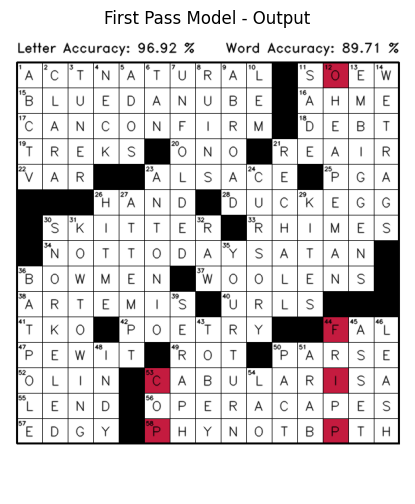

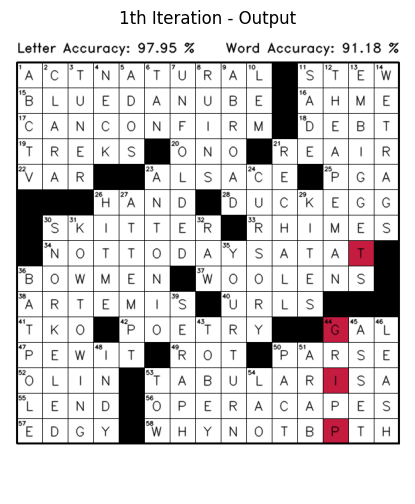

In [6]:
for img_solution, title_name in grid_img_solutions:
    gray = cv2.cvtColor(img_solution, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (6, 6))
    plt.imshow(gray)
    plt.axis('off')
    plt.title(title_name)
    plt.show()